# Survey data demographics analysis

- Representativeness: How do the survey participant demographics compare to the US?
- Overall, what are the distributions of demographics and other characteristics?



## Methods used below

Overall, we compare our survey data participant characteristics to census data, using data from 2022, or as close to 2022 as available at time of analysis.

### Calculating bias

For each category we calculate:

- observed proportion: survey sample size for group / total survey data sample size
- expected proportion: census data count for group / census data total population

Bias = (observed proportion) - (expected proportion)

### Pearson correlation

Also characterize bias by looking at the Pearson correlation coefficient across all groups.


In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare, pearsonr

census_data_dir = '../data/census/'
data_filepath = '../data/survey-data/survey.csv'
fields_filepath = '../data/survey-data/fields.csv'

In [100]:
# only inspect the fields related to demographics of interest for this notebook
demo_fields = [
    'ResponseId',
    'q-demos-age', 
    'Q-demos-hispanic', 'Q-demos-race',
    'Q-demos-education', 
    'Q-demos-income', 
    'Q-demos-gender',
    'Q-sexual-orientation', 
    'Q-demos-state',
    # Not like the others: purchase frequency
    'Q-amazon-use-how-oft'
]
# Here are the fields
fields_df = pd.read_csv(fields_filepath, index_col=0).loc[demo_fields]
fields_df

,fields
ResponseId,Response ID
q-demos-age,What is your age group?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-education,What is the highest level of education you hav...
Q-demos-income,What was your total household income before ta...
Q-demos-gender,How do you describe yourself?
Q-sexual-orientation,Which best describes your sexual orientation?
Q-demos-state,"50 States, D.C. and Puerto Rico"
Q-amazon-use-how-oft,How often do you (+ anyone you share your acco...


In [101]:
df = pd.read_csv(data_filepath)[demo_fields]
print('%s total sample N' % len(df))
df.head(4)

6325 total sample N


,ResponseId,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-how-oft
0,R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,heterosexual (straight),Iowa,Less than 5 times per month
1,R_24dboHVOzohx1kw,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Male,heterosexual (straight),Florida,Less than 5 times per month
2,R_2UbJL30HRjK1sdD,45 - 54 years,No,White or Caucasian,High school diploma or GED,"$100,000 - $149,999",Male,heterosexual (straight),Ohio,Less than 5 times per month
3,R_UPXamGKtmf4RVIZ,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),Arkansas,Less than 5 times per month


## Helper functions

In [4]:
def set_proportions_and_bias(df, roundto=3):
    """
    Adds columns for census proportion, survey proportion, bias
    Expects dataframe (df) with columns 'census N', 'survey N'
    Returns updated df
    """
    df['census proportion'] = round(df['census N']/df['census N'].sum(), roundto)
    df['survey proportion'] = round(df['survey N']/df['survey N'].sum(), roundto)
    df['bias'] = df['survey proportion'] - df['census proportion']
    return df

In [5]:
# Plots to compare survey vs census data

def plot_bias(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    df['bias'].plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (df['census proportion']
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (df['survey proportion']
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('proportion')
    if title:
        ax.set_title(title)
    return ax

In [6]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.03
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )

def plot_survey_proportion_with_N(df, ax):
    ax.barh(df.index, df['survey proportion'], color='lightgray',  edgecolor='black')
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    # annotate with labels
    add_n_labels(ax, df['survey N'])

## Compare state populations

We use 2022 census data for the 18+ population (because our participants were limited to 18+)

Source: U.S. Census Bureau, Population Division	
> Estimates of the Total Resident Population and Resident Population Age 18 Years and Older for the United States, Regions, States, District of Columbia, and Puerto Rico: July 1, 2022 (SCPRC-EST2022-18+POP)			

Release Date: December 2022			
	
Downloaded from:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html


To compare, make a table:

```
state, census N, census proportion, survey N, survey proportion, bias
```

Notes from comparison:
- No participants from Puerto Rico in our dataset
- Overall high correlation
- Survey under represents CA and TX
- Survey over represents PA

In [7]:
# load census data
state_pop_census_data_path = census_data_dir + 'population-by-state.csv'
state_pop_df = pd.read_csv(state_pop_census_data_path, thousands=',').set_index('state').rename(columns={'population':'census N'})
print('%s states and regions in census data' % len(state_pop_df))
print('summed population (18+): %s' % state_pop_df['census N'].sum())
state_pop_df.head()

52 states and regions in census data
summed population (18+): 263540180


,census N
state,
Alabama,3962734
Alaska,557060
Arizona,5770187
Arkansas,2348518
California,30523315


Pearson correlation (r, pvalue): (0.981, 0.000)


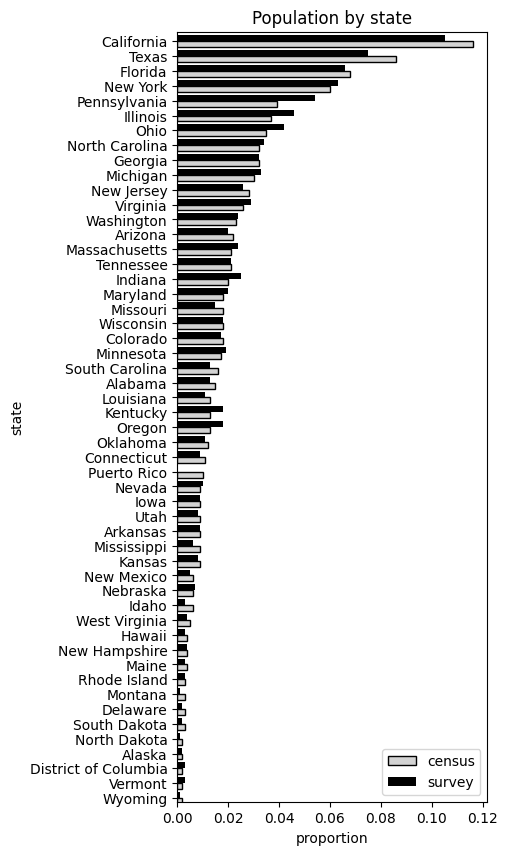

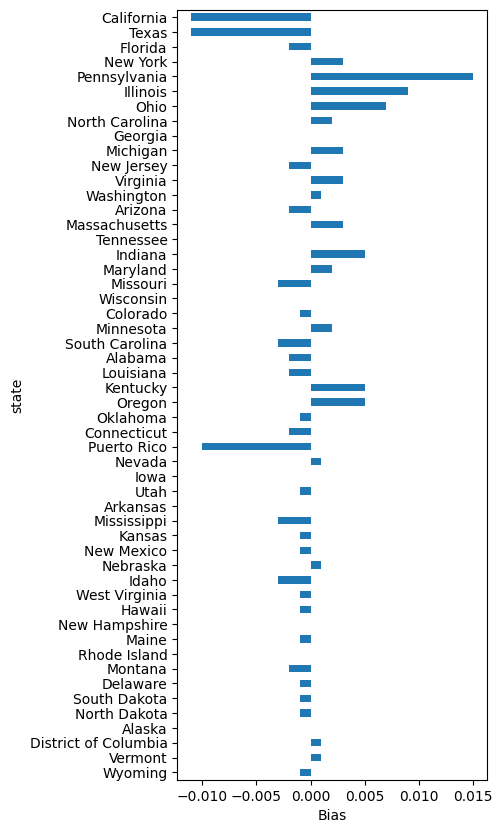

,census N,survey N,census proportion,survey proportion,bias
state,,,,,
Alabama,3962734,82.0,0.015,0.013,-0.002
Alaska,557060,11.0,0.002,0.002,0.000
Arizona,5770187,129.0,0.022,0.020,-0.002
Arkansas,2348518,55.0,0.009,0.009,0.000
California,30523315,662.0,0.116,0.105,-0.011
Colorado,4624351,109.0,0.018,0.017,-0.001
Connecticut,2895175,56.0,0.011,0.009,-0.002
Delaware,810269,14.0,0.003,0.002,-0.001
District of Columbia,547328,16.0,0.002,0.003,0.001


In [8]:
state_pop_df['survey N'] = state_pop_df.index.map(df['Q-demos-state'].value_counts()).fillna(0)
state_pop_df = set_proportions_and_bias(state_pop_df)

(r, pvalue) = pearsonr(state_pop_df['census proportion'], state_pop_df['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
fig,ax = plt.subplots(figsize=(4,10))
_ax = plot_census_vs_survey_pops(state_pop_df.sort_values('census N'), ax=ax, title='Population by state')
plt.show()
fig,ax = plt.subplots(figsize=(4,10))
_ax = plot_bias(state_pop_df.sort_values('census N'), ax=ax)
plt.show()
state_pop_df

## Compare gender


Census data for 18+ population:
```
Male: 49.00%
Female: 51.00%
```

From DP05: ACS DEMOGRAPHIC AND HOUSING ESTIMATES (2021) 5-Year estimates.

Notes:
- Our survey did not limit to a male/female binary.
- When we do limit to the male/female binary, our survey data proportions match census estimates!

How do you describe yourself?


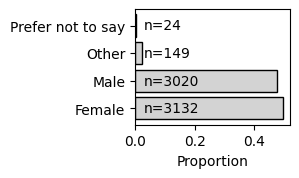

,survey N,survey proportion
Q-demos-gender,,
Female,3132,0.495178
Male,3020,0.477470
Other,149,0.023557
Prefer not to say,24,0.003794


In [9]:
print(fields_df.loc['Q-demos-gender'][0])
gender_df = df['Q-demos-gender'].value_counts().rename('survey N').to_frame()
gender_df['survey proportion'] = gender_df['survey N']/gender_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(2,1.5), dpi=100)
# ax.barh(gender_df.index,gender_df['survey proportion'])
plot_survey_proportion_with_N(gender_df, ax)
plt.show()
gender_df

To compare directly to census data we limit to Male/Female binary and redo calculation.

In [10]:
gender_df = gender_df.loc[['Female', 'Male']]
gender_df['survey proportion'] = round(gender_df['survey N']/gender_df['survey N'].sum(), 3)
gender_df['census proportion'] = [0.51, 0.49]
gender_df

,survey N,survey proportion,census proportion
Q-demos-gender,,,
Female,3132,0.509,0.51
Male,3020,0.491,0.49


## Compare age groups

Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)


About the data:
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:
- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population.
(i.e. AGE=100 includes 100+)

We use totals, aggregating over age, limiting to 18+


In [11]:
census_age_df = pd.read_csv(census_data_dir + 'age-by-sex-2022-est.csv')
census_age_df

# Can drop total because we recalculate total without < 18
census_age_df = census_age_df[(census_age_df['SEX']==0) & (census_age_df['AGE']<= 100)].rename(
    columns={'POPESTIMATE2022': 'N'}
).drop('SEX', axis=1)
# First calculate the number of people less than 18
print('census N=%s with age < 18; we drop them' % census_age_df[census_age_df['AGE']<18]['N'].sum())
census_age_df = census_age_df[(census_age_df['AGE']>= 18)]
# Can drop folks < 18
census_age_df

census N=72450827 with age < 18; we drop them


,AGE,N
18,18,4326642
19,19,4295710
20,20,4438006
21,21,4723644
22,22,4663473
...,...,...
96,96,145421
97,97,109622
98,98,78028
99,99,53870


In [12]:
print('Our survey data:')
age_df = df['q-demos-age'].value_counts().sort_index().rename('survey N').to_frame()
age_df

Our survey data:


,survey N
q-demos-age,
18 - 24 years,990
25 - 34 years,2312
35 - 44 years,1545
45 - 54 years,824
55 - 64 years,461
65 and older,193


Pearson correlation (r, pvalue): (-0.225, 0.668)


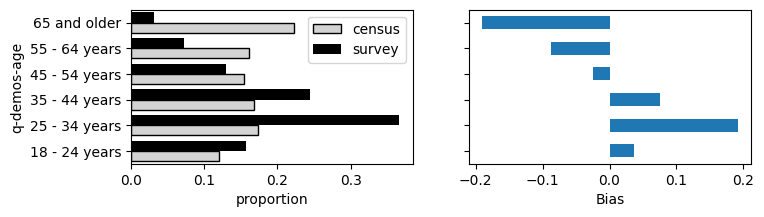

,survey N,census N,census proportion,survey proportion,bias
q-demos-age,,,,,
18 - 24 years,990,31328131,0.120,0.157,0.037
25 - 34 years,2312,45501300,0.174,0.366,0.192
35 - 44 years,1545,43695365,0.168,0.244,0.076
45 - 54 years,824,40431645,0.155,0.130,-0.025
55 - 64 years,461,42085437,0.161,0.073,-0.088
65 and older,193,57794852,0.222,0.031,-0.191


In [13]:
# Aggregate census data to age groups matching survey data
age_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 65]['N'].sum(),
]
age_df = set_proportions_and_bias(age_df)
# Calculate Pearson correlation
(r, pvalue) = pearsonr(age_df['census proportion'], age_df['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_df, ax=ax1)
plot_bias(age_df, ax=ax2)
plt.show()
age_df

Notes:
- Our data is highly biased w.r.t. age. 
- Overall sample under represents people older than 45, over represents younger than 45
- Sample greatly under represents people older than 55
- Sample greatly over represents people 25-34

## Household income distribution

We use:
HINC-01. Selected Characteristics of Households by Total Money Income in 2021

Source: 
> U.S. Census Bureau, Current Population Survey, 2022 Annual Social and Economic Supplement (CPS ASEC).	

At time of analysis, 2022 estimates not available.
2022 survey data weres used to produce estimates for 2021.

Census data are reported in the 1000's

Our survey data:
What was your total household income before taxes during the past 12 months?


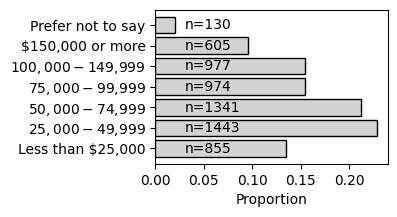

,survey N,survey proportion
Q-demos-income,,
"Less than $25,000",855,0.135178
"$25,000 - $49,999",1443,0.228142
"$50,000 - $74,999",1341,0.212016
"$75,000 - $99,999",974,0.153992
"$100,000 - $149,999",977,0.154466
"$150,000 or more",605,0.095652
Prefer not to say,130,0.020553


In [89]:
print('Our survey data:')
Q = 'Q-demos-income'
print(fields_df.loc[Q][0])
income_groups = [
    'Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999','$75,000 - $99,999',
    '$100,000 - $149,999', '$150,000 or more', 'Prefer not to say'
]
income_df = df[Q].value_counts().rename('survey N').to_frame().reindex(income_groups)
income_df['survey proportion'] = income_df['survey N']/income_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(3,2), dpi=100)
plot_survey_proportion_with_N(income_df, ax)
plt.show()
income_df

In [90]:
# census data
census_income_df = pd.read_csv(census_data_dir + 'hinc01-totals.csv', thousands=',').transpose()
census_income_df.columns = ['N']
# print(census_income_df.index)
census_income_df.head()

,N
Total,131202
"Under $5,000",4299
"$5,000 to $9,999",2658
"$10,000 to $14,999",5309
"$15,000 to $19,999",5202


Pearson correlation (r, pvalue): (0.094, 0.859)


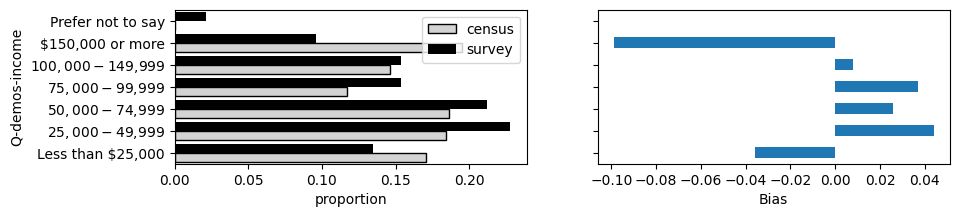

,survey N,survey proportion,census N,census proportion,bias
Q-demos-income,,,,,
"Less than $25,000",855,0.135,22880.0,0.171,-0.036
"$25,000 - $49,999",1443,0.228,24616.0,0.184,0.044
"$50,000 - $74,999",1341,0.212,24833.0,0.186,0.026
"$75,000 - $99,999",974,0.154,15559.0,0.117,0.037
"$100,000 - $149,999",977,0.154,19495.0,0.146,0.008
"$150,000 or more",605,0.096,26062.0,0.195,-0.099
Prefer not to say,130,0.021,NaN,NaN,NaN


In [94]:
# income_df = income_df.loc[income_groups]
income_df['census N'] = [
    census_income_df.loc[[
        'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$50,000 to $54,999', '$55,000 to $59,999', '$60,000 to $64,999', '$65,000 to $69,999', '$70,000 to $74,999','$75,000 to $79,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$75,000 to $79,999', '$80,000 to $84,999', '$85,000 to $89,999','$90,000 to $94,999', '$95,000 to $99,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$100,000 to $104,999','$105,000 to $109,999', '$110,000 to $114,999', 
        '$115,000 to $119,999','$120,000 to $124,999', '$125,000 to $129,999', 
        '$130,000 to $134,999','$135,000 to $139,999', '$140,000 to $144,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$150,000 to $154,999', '$155,000 to $159,999', '$160,000 to $164,999',
        '$165,000 to $169,999', '$170,000 to $174,999', '$175,000 to $179,999',
        '$180,000 to $184,999', '$185,000 to $189,999', '$190,000 to $194,999',
        '$195,000 to $199,999', '$200,000 and over'
    ]]['N'].sum(),
    np.nan,
]
income_df = set_proportions_and_bias(income_df)

# Calculate Pearson correlation -- drop 'Prefer not to say'
(r, pvalue) = pearsonr(income_df.drop('Prefer not to say')['census proportion'],
                       income_df.drop('Prefer not to say')['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2), sharey=True)
plot_census_vs_survey_pops(income_df, ax=ax1)
plot_bias(income_df, ax=ax2)
plt.show()

income_df

Notes:

- Survey data is very biased w.r.t. household income distribution
- survey sample greatly under represents households making > \$150k
- survey sample also under represents households making < \$25k

## Education

Educational Attainment in the United States: 2022

Source: 
> U.S. Census Bureau, Current Population Survey, 2022 Annual Social and Economic Supplement (CPS ASEC).

Census data are again in the 1,000's.

Our survey data:
What is the highest level of education you have completed?


,survey N,survey proportion
Q-demos-education,,
Some high school or less,60,0.009486
High school diploma or GED,2280,0.360474
Bachelor's degree,2834,0.448063
Graduate or professional degree,1086,0.171700
Prefer not to say,65,0.010277


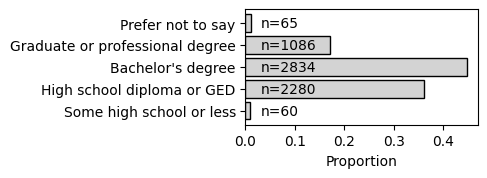

In [95]:
print('Our survey data:')
Q = 'Q-demos-education'
print(fields_df.loc[Q][0])
edu_groups = [
    'Some high school or less', 'High school diploma or GED', 'Bachelor\'s degree',
    'Graduate or professional degree', 'Prefer not to say'
]
edu_df = (df[Q].value_counts().rename('survey N').to_frame()
          # rename this very long index value
          .rename(index={'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)': 'Graduate or professional degree'})
          .reindex(edu_groups))
edu_df['survey proportion'] = edu_df['survey N']/edu_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(3,1.5), dpi=100)
plot_survey_proportion_with_N(edu_df, ax)
# plt.show()
edu_df

In [96]:
census_edu_df = pd.read_csv(census_data_dir + 'education-attainment-2022.csv', thousands=',').transpose()
census_edu_df.columns = ['N']
# print(census_edu_df.index)
census_edu_df.head()

,N
Total,255255
None,770
1st - 4th grade,1518
5th - 6th grade,2812
7th - 8th grade,3201


Pearson correlation (r, pvalue): (0.602, 0.398)


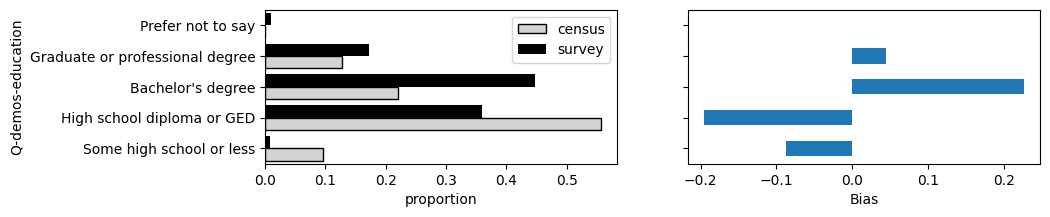

,survey N,survey proportion,census N,census proportion,bias
Q-demos-education,,,,,
Some high school or less,60,0.009,24393.0,0.096,-0.087
High school diploma or GED,2280,0.360,142017.0,0.556,-0.196
Bachelor's degree,2834,0.448,56350.0,0.221,0.227
Graduate or professional degree,1086,0.172,32497.0,0.127,0.045
Prefer not to say,65,0.010,NaN,NaN,NaN


In [99]:
# edu_groups = edu_groups = [
#     'Some high school or less', 'High school diploma or GED', 'Bachelor\'s degree',
#     'Graduate or professional degree'
# ]
# edu_df = edu_df.loc[edu_groups]
edu_df['census N'] = [
    census_edu_df.loc[[
        'None', '1st - 4th grade', '5th - 6th grade', '7th - 8th grade', '9th grade', '10th grade', '11th grade2',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'High school graduate3', 'Some college, no degree', 'Associate\'s degree, occupational', 'Associate\'s degree, academic',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'Bachelor\'s degree',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'Master\'s degree', 'Professional degree', 'Doctoral degree'
    ]]['N'].sum(),
    np.nan
]
edu_df = set_proportions_and_bias(edu_df)

# Calculate Pearson correlation
(r, pvalue) = pearsonr(edu_df['census proportion'].drop('Prefer not to say'),
                       edu_df['survey proportion'].drop('Prefer not to say'))
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2), sharey=True)
plot_census_vs_survey_pops(edu_df, ax=ax1)
plot_bias(edu_df, ax=ax2)
plt.show()
edu_df

Notes:
- The sample is highly biased w.r.t. educational attainment
- sample greatly over represents people with a bachelor's degree
- sample greatly under represents people with a highschool diploma or less

## Sexual orientation

A quick look at the number of sample participants identifying as LGBTQ+

Which best describes your sexual orientation?


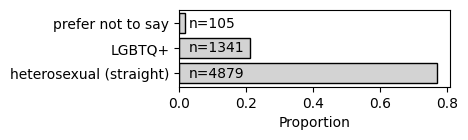

,survey N,survey proportion
Q-sexual-orientation,,
heterosexual (straight),4879,0.771383
LGBTQ+,1341,0.212016
prefer not to say,105,0.016601


In [20]:
Q = 'Q-sexual-orientation'
print(fields_df.loc[Q][0])
sexual_orientation_df = df[Q].value_counts().rename('survey N').to_frame()
sexual_orientation_df['survey proportion'] = sexual_orientation_df['survey N']/sexual_orientation_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(3.5,1), dpi=100)
plot_survey_proportion_with_N(sexual_orientation_df, ax)
plt.show()
sexual_orientation_df

## Race and Spanish/Latino/Hispanic origin

Note that both the census and our survey ask separately for Spanish/Hispanic origin.

We use table NC-EST2021-SR11H.

Note race data slightly differs across sources offered by the census.

Suggested Citation:			
> Annual Estimates of the Resident Population by Sex, Race, and Hispanic Origin for the United States: April 1, 2020 to July 1, 2021 (NC-EST2021-SR11H)			

Source: U.S. Census Bureau, Population Division			
Release Date: June 2022	

Downloaded from:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html

Data available [here](https://docs.google.com/spreadsheets/d/1i3OAjXzCX8CnRfybB_WEuRIFKKMtEsMrFt2A_T0qFwY/edit#gid=1363938624).

---

From US census quick facts: 
https://www.census.gov/quickfacts/fact/table/US/RHI125221

- 75.8%: White alone
- 18.9% Hispanic or Latino

The census source notes: Hispanics may be of any race, so also are included in applicable race categories

--- 

#### Notes

- Our data is highly correlated with census data w.r.t. race (p<0.001)
- Black participants underrepresented


### Spanish Hispanic origin

Are you of Spanish, Hispanic, or Latino origin?


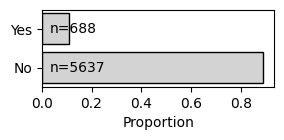

,survey N,survey proportion
Q-demos-hispanic,,
No,5637,0.891
Yes,688,0.109


In [21]:
Q = 'Q-demos-hispanic'
print(fields_df.loc[Q][0])
hisp_df = df[Q].value_counts().rename('survey N').to_frame()
hisp_df['survey proportion'] = round(hisp_df['survey N']/hisp_df['survey N'].sum(), 3)
fig, ax = plt.subplots(figsize=(3,1), dpi=100)
plot_survey_proportion_with_N(hisp_df, ax)
plt.show()
hisp_df

### Race

Census data

In [48]:
census_race_df = pd.read_csv(census_data_dir + 'race-2021-est.csv', thousands=',').set_index('race')
assert(
    census_race_df.loc['TOTAL POPULATION']['population'] == census_race_df.drop('TOTAL POPULATION').sum()['population'] 
)
# safe to drop total population give above assert
census_race_df.drop('TOTAL POPULATION', inplace=True)
census_race_df

,population
race,
White,251461611
Black or African American,45060857
American Indian and Alaska Native,4367540
Asian,20350483
Native Hawaiian and Other Pacific Islander,863043
Two or More Races,9790211


Survey data

Note the census data does not have an 'Other' category. That's fine.

In [78]:
# First just show what the data looks like
Q = 'Q-demos-race'
print(fields_df.loc[Q][0])
race_df = df[Q].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(8)

Choose one or more races that you consider yourself to be


,survey N,survey proportion
Q-demos-race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Black or African American,440,0.070
Other,134,0.021
"White or Caucasian,Asian",96,0.015
"White or Caucasian,Black or African American",72,0.011
"White or Caucasian,American Indian/Native American or Alaska Native",66,0.010
American Indian/Native American or Alaska Native,38,0.006


Pearson correlation (r, pvalue): (0.994, 0.000)


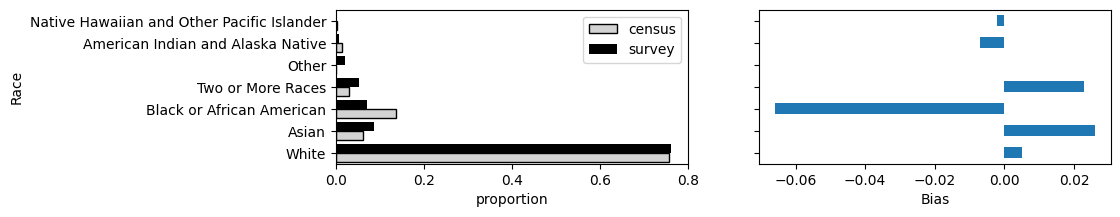

,survey N,census N,census proportion,survey proportion,bias
Race,,,,,
White,4825,251461611.0,0.758,0.763,0.005
Asian,551,20350483.0,0.061,0.087,0.026
Black or African American,440,45060857.0,0.136,0.070,-0.066
Two or More Races,330,9790211.0,0.029,0.052,0.023
Other,134,NaN,NaN,0.021,NaN
American Indian and Alaska Native,38,4367540.0,0.013,0.006,-0.007
Native Hawaiian and Other Pacific Islander,7,863043.0,0.003,0.001,-0.002


In [74]:
# Map two or more races to 'Two or more races'
# And map the names to match the census data
race_df = (df[Q].apply(lambda r: 'Two or More Races' if (len(r.split(',')) > 1) else r)
           .value_counts().rename('survey N').to_frame()
           .rename({
               'White or Caucasian': 'White',
               'Native Hawaiian or Other Pacific Islander':'Native Hawaiian and Other Pacific Islander',
               'American Indian/Native American or Alaska Native': 'American Indian and Alaska Native',
           }))
race_df.index.rename('Race', inplace=True)

race_df['census N'] = race_df.index.map(census_race_df['population'])
race_df = set_proportions_and_bias(race_df)
# Calculate Pearson correlation - Drop 'Other' for this calculation
(r, pvalue) = pearsonr(race_df.drop('Other')['census proportion'], 
                       race_df.drop('Other')['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2), sharey=True)
plot_census_vs_survey_pops(race_df, ax=ax1)
plot_bias(race_df, ax=ax2)
plt.show()
race_df

## Purchase frequency

This is not a demographic reported by the census. But it is interesting data we collected and use.

How often do you (+ anyone you share your account with) order deliveries from Amazon?


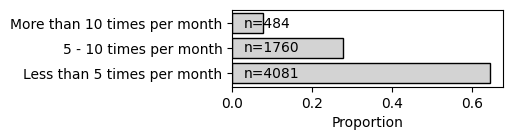

,survey N,survey proportion
Q-amazon-use-how-oft,,
Less than 5 times per month,4081,0.645
5 - 10 times per month,1760,0.278
More than 10 times per month,484,0.077


In [103]:
Q = 'Q-amazon-use-how-oft'
print(fields_df.loc[Q][0])
freq_df = df[Q].value_counts().rename('survey N').to_frame()
freq_df['survey proportion'] = round(freq_df['survey N']/freq_df['survey N'].sum(), 3)
fig, ax = plt.subplots(figsize=(3.5,1), dpi=100)
plot_survey_proportion_with_N(freq_df, ax)
plt.show()
freq_df